In [2]:
import tensorflow as tf
# tf.enable_eager_execution()

In [3]:
import pandas as pd
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.python.keras.utils import np_utils
from nltk.tokenize import RegexpTokenizer
from tensorflow.keras.models import Model,load_model
from tensorflow.keras.callbacks import ModelCheckpoint
from nltk.stem import WordNetLemmatizer
from tqdm import tqdm
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import Callback

from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score
import seaborn as sns
from sklearn.feature_extraction import text as sktext
from sklearn import preprocessing as skp
from tensorflow.keras import callbacks as kc
from tensorflow.keras import optimizers as ko
from tensorflow.keras import initializers, regularizers, constraints
#from tensorflow.keras.engine import Layer
import tensorflow.keras.backend as K
from sklearn.metrics import f1_score
from tensorflow.python.keras.utils.vis_utils import model_to_dot
from tensorflow.keras import models
from tensorflow.keras import layers
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
%matplotlib inline

import os
import time
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from tqdm import tqdm
import math
from sklearn.model_selection import train_test_split
from sklearn import metrics

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense, Input, Embedding, Dropout, Activation, GRU, Conv1D
from tensorflow.keras.layers import Bidirectional, GlobalMaxPool1D, Flatten, GlobalAveragePooling1D, Reshape
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
#from tensorflow.python.keras.engine.topology import Layer
from tensorflow.keras import initializers, regularizers, constraints, optimizers, layers
from tensorflow.keras.initializers import Constant


In [4]:
# from tensorflow.contrib.cudnn_rnn import CudnnLSTM

In [5]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="2"

In [6]:
df = pd.read_csv('final_HEOT_data.csv')
train_df = pd.read_csv('processed_HEOT_data.csv')

In [7]:
train_df.head()

,Unnamed: 0,content,class
0,0,haa jaise tum bhi abhi,0
1,1,banti hai empowered woman feminism gyan pelti ...,2
2,2,usko chhod mjse bat tera baap gya hai ldki bee...,2
3,3,punjab madarchodon khila raha hai nokrian day ...,2
4,4,agar koi bole chill maar madarchod gand maar lene,2


In [8]:
train_df['class'] = train_df['class'].astype(int)
train_df = train_df.drop(['Unnamed: 0'], axis=1)

In [9]:
train_df['content']

0                                  haa jaise tum bhi abhi
1       banti hai empowered woman feminism gyan pelti ...
2       usko chhod mjse bat tera baap gya hai ldki bee...
3       punjab madarchodon khila raha hai nokrian day ...
4       agar koi bole chill maar madarchod gand maar lene
                              ...                        
3025    dekha tera islamic kashmirijihaadi suar bhai jisk
3026                  all love jihaadi should killed aise
3027      dekh madarjaat rand aullad tera islamic jihaadi
3028        waise jihaadi kutte double maut aane wali hai
3029    kya madam abhi tak apne aapne hindu jihaadi bh...
Name: content, Length: 3030, dtype: object

In [10]:
df['label'] = df['label'].astype(int)

In [11]:
df = df.drop(['Unnamed: 0'], axis=1)

In [12]:
train_df = pd.DataFrame()
train_df['content'] = df['lemmas']
train_df['class'] = df['label']

Training data phrase length distribution


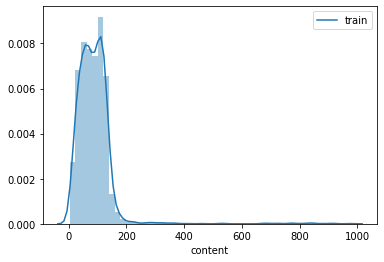

In [13]:
print("Training data phrase length distribution")
sns.distplot(train_df['content'].map(lambda ele: len(ele)), kde_kws={"label": "train"})

In [14]:
print('Most frequent sentence length in training:')
lens = train_df['content'].map(lambda ele: len(ele))
counts = np.bincount(lens)
print(np.argmax(counts))

Most frequent sentence length in training:
55


Testing data phrase length distribution


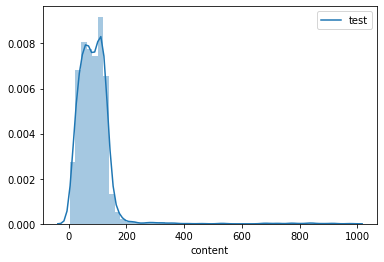

In [15]:
print("Testing data phrase length distribution")
sns.distplot(train_df['content'].map(lambda ele: len(ele)), kde_kws={"label": "test"})

In [16]:
train_df.shape

(3189, 2)

In [17]:
test_df = train_df[2800:]
train_df = train_df[:2800]

Testing data phrase length distribution


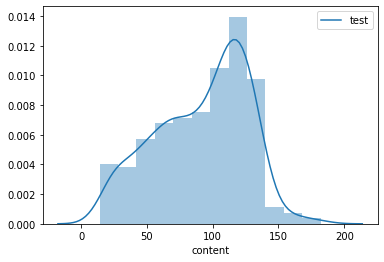

In [18]:
print("Testing data phrase length distribution")
sns.distplot(test_df['content'].map(lambda ele: len(ele)), kde_kws={"label": "test"})

In [19]:
print('Most frequent sentence length in testing:')
lens = test_df['content'].map(lambda ele: len(ele))
counts = np.bincount(lens)
print(np.argmax(counts))

Most frequent sentence length in testing:
115


In [20]:
punct = "/-'?!.,#$%\'()*+-/:;<=>@[\\]^_`{|}~" + '""“”’' + '∞θ÷α•à−β∅³π‘₹´°£€\×™√²—–&'

In [21]:

## A dictionary to map the punctuations present in the text to relevant strings or symbols
punct_mapping = {"‘": "'", 
                 "₹": "e", 
                 "´": "'", 
                 "°": "", 
                 "€": "e", 
                 "™": "tm",
                 "√": " sqrt ",
                 "×": "x",
                 "²": "2",
                 "—": "-",
                 "–": "-",
                 "’": "'",
                 "_": "-",
                 "`": "'",
                 '“': '"',
                 '”': '"',
                 '“': '"',
                 "£": "e",
                 '∞': 'infinity',
                 'θ': 'theta',
                 '÷': '/',
                 'α': 'alpha',
                 '•': '.',
                 'à': 'a',
                 '−': '-',
                 'β': 'beta',
                 '∅': '',
                 '³': '3',
                 'π': 'pi',
                 ',':'',
                 '.':'',
                 ':':'',
                 '(':'',
                 ')':'',
                 '*':'',
                '"':'',
                '<':'',
                '>':''}

In [22]:
def unknown_punct(embed, punct):
    unknown = ''
    for p in punct:
        if p not in embed:
            unknown += p
            unknown += ' '
    return unknown

## Function to remove special characters from the sentences (if any present)
def clean_special_chars(text, punct, mapping):
    for p in mapping:
        text = text.replace(p, mapping[p])
    
    specials = {'\u200b': ' ', '…': ' ... ', '\ufeff': '', 'करना': '', 'है': ''}  # Other special characters that I have to deal with in last
    for s in specials:
        text = text.replace(s, specials[s])
    
    return text

In [23]:
train_df.loc[:, 'content'] = train_df['content'].map(lambda text: clean_special_chars(text, punct, punct_mapping))
test_df.loc[:, 'content'] = test_df['content'].map(lambda text: clean_special_chars(text, punct, punct_mapping))

In [24]:
contraction_mapping = {"ain't": "is not", "aren't": "are not","can't": "cannot", 
                   "can't've": "cannot have", "'cause": "because", "could've": "could have", 
                   "couldn't": "could not", "couldn't've": "could not have","didn't": "did not", 
                   "doesn't": "does not", "don't": "do not", "hadn't": "had not", 
                   "hadn't've": "had not have", "hasn't": "has not", "haven't": "have not", 
                   "he'd": "he would", "he'd've": "he would have", "he'll": "he will", 
                   "he'll've": "he will have", "he's": "he is", "how'd": "how did", 
                   "how'd'y": "how do you", "how'll": "how will", "how's": "how is", 
                   "I'd": "I would", "I'd've": "I would have", "I'll": "I will", 
                   "I'll've": "I will have","I'm": "I am", "I've": "I have", 
                   "i'd": "i would", "i'd've": "i would have", "i'll": "i will", 
                   "i'll've": "i will have","i'm": "i am", "i've": "i have", 
                   "isn't": "is not", "it'd": "it would", "it'd've": "it would have", 
                   "it'll": "it will", "it'll've": "it will have","it's": "it is", 
                   "let's": "let us", "ma'am": "madam", "mayn't": "may not", 
                   "might've": "might have","mightn't": "might not","mightn't've": "might not have", 
                   "must've": "must have", "mustn't": "must not", "mustn't've": "must not have", 
                   "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock", 
                   "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not",
                   "sha'n't": "shall not", "shan't've": "shall not have", "she'd": "she would", 
                   "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", 
                   "she's": "she is", "should've": "should have", "shouldn't": "should not", 
                   "shouldn't've": "should not have", "so've": "so have","so's": "so as", 
                   "this's": "this is",
                   "that'd": "that would", "that'd've": "that would have","that's": "that is", 
                   "there'd": "there would", "there'd've": "there would have","there's": "there is", 
                       "here's": "here is",
                   "they'd": "they would", "they'd've": "they would have", "they'll": "they will", 
                   "they'll've": "they will have", "they're": "they are", "they've": "they have", 
                   "to've": "to have", "wasn't": "was not", "we'd": "we would", 
                   "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", 
                   "we're": "we are", "we've": "we have", "weren't": "were not", 
                   "what'll": "what will", "what'll've": "what will have", "what're": "what are", 
                   "what's": "what is", "what've": "what have", "when's": "when is", 
                   "when've": "when have", "where'd": "where did", "where's": "where is", 
                   "where've": "where have", "who'll": "who will", "who'll've": "who will have", 
                   "who's": "who is", "who've": "who have", "why's": "why is", 
                   "why've": "why have", "will've": "will have", "won't": "will not", 
                   "won't've": "will not have", "would've": "would have", "wouldn't": "would not", 
                   "wouldn't've": "would not have", "y'all": "you all", "y'all'd": "you all would",
                   "y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                   "you'd": "you would", "you'd've": "you would have", "you'll": "you will", 
                   "you'll've": "you will have", "you're": "you are", "you've": "you have" }

In [25]:
def clean_contractions(text, mapping):
    specials = ["’", "‘", "´", "`"]
    for s in specials:
        text = text.replace(s, "'")
    text = ' '.join([mapping[t] if t in mapping else t for t in text.split(" ")])
    return text

In [26]:
train_df.loc[:, 'content'] = train_df['content'].map(lambda text: clean_contractions(text, contraction_mapping))
test_df.loc[:, 'content'] = test_df['content'].map(lambda text: clean_contractions(text, contraction_mapping))

In [27]:
train_df.loc[:, 'content'] = train_df['content'].map(lambda text: text.lower())
test_df.loc[:, 'content'] = test_df['content'].map(lambda text: text.lower())

In [28]:
data = train_df.values
data_test = test_df.values

In [29]:
X_train = data[:,0]
Y_train = data[:,1]

X_test = data_test[:,0]
Y_test = data_test[:,1]

print (X_train.shape, Y_train.shape, X_test.shape, Y_test.shape)
print ("-------------------------")
print (X_test[0], Y_test[0])
print (X_train[0], Y_train[0])

(2800,) (2800,) (389,) (389,)
-------------------------
itna maar khayega man why do not you understand 0
user user user user user user user user haa jaise tum bhi abhi pxe2x80xa6 url 0


In [30]:
tokenizer = RegexpTokenizer("[a-zA-Z]+")
lemmatizer = WordNetLemmatizer()

In [31]:
for ix in range(X_train.shape[0]):
    try:
        X_train[ix] = tokenizer.tokenize(X_train[ix])
        X_train[ix] = [lemmatizer.lemmatize(i) for i in X_train[ix]]
    except:
        print ( X_train[ix] )
    
for ix in range(X_test.shape[0]):
    X_test[ix] = tokenizer.tokenize(X_test[ix])
    X_test[ix] = [lemmatizer.lemmatize(i) for i in X_test[ix]]

In [32]:

unique_words = set()
len_max = 0

for sent in tqdm(X_train):
    
    unique_words.update(sent)
#     print(sent)
    
    if(len_max<len(sent)):
        len_max = len(sent)
        
## Length of the list of unique_words gives the no of unique words
print("Vocabulary Size:")
print(len(list(unique_words)))
print("Maximum length of sentence:")
print(len_max)

100%|██████████| 2800/2800 [00:00<00:00, 835875.53it/s]

Vocabulary Size:
7656
Maximum length of sentence:
295


In [33]:
tokenizer_keras = Tokenizer(num_words=len(list(unique_words)))
tokenizer_keras.fit_on_texts(list(X_train))
X_train = tokenizer_keras.texts_to_sequences(X_train)
X_test = tokenizer_keras.texts_to_sequences(X_test)

## Padding done to equalize the lengths of all input reviews. LSTM networks needs all inputs to be same length.
## Therefore reviews lesser than max length will be made equal using extra zeros at end. This is padding.
X_train = sequence.pad_sequences(X_train, maxlen=len_max, padding = "post")
X_test = sequence.pad_sequences(X_test, maxlen=len_max, padding = "post")
print(X_train.shape,X_test.shape)

(2800, 295) (389, 295)


In [34]:
embeddings_index = dict()

In [35]:
from gensim.models import Word2Vec
from gensim.test.utils import common_texts

In [36]:
model = Word2Vec.load("word2vec.model")

In [37]:
word_vectors = model.wv

In [38]:
print(data[:,0])

[list(['user', 'user', 'user', 'user', 'user', 'user', 'user', 'user', 'haa', 'jaise', 'tum', 'bhi', 'abhi', 'pxe', 'x', 'xa', 'url'])
 list(['banti', 'hai', 'empower', 'woman', 'feminism', 'pe', 'gyan', 'pelti', 'hai', 'aur', 'din', 'bhar', 'roti', 'rehti', 'hai', 'pahle', 'rona', 'band', 'kar', 'madarchod'])
 list(['rt', 'user', 'user', 'user', 'ab', 'usko', 'chhod', 'mjse', 'bat', 'kr', 'tera', 'baap', 'aa', 'gya', 'hai', 'ab', 'to', 'ldki', 'ko', 'beech', 'me', 'q', 'la', 'ra', 'hai', 'madarchod', 'txe', 'x', 'xa'])
 ... list(['bjp', 'will', 'win', 'jai', 'ram', 'modi', 'bhagwan'])
 list(['kya', 'karna', 'hai', 'ab', 'bol'])
 list(['sab', 'mar', 'jayenge', 'ba', 'main', 'zinda', 'rahunga'])]


In [39]:
data[:,0]

array([list(['user', 'user', 'user', 'user', 'user', 'user', 'user', 'user', 'haa', 'jaise', 'tum', 'bhi', 'abhi', 'pxe', 'x', 'xa', 'url']),
       list(['banti', 'hai', 'empower', 'woman', 'feminism', 'pe', 'gyan', 'pelti', 'hai', 'aur', 'din', 'bhar', 'roti', 'rehti', 'hai', 'pahle', 'rona', 'band', 'kar', 'madarchod']),
       list(['rt', 'user', 'user', 'user', 'ab', 'usko', 'chhod', 'mjse', 'bat', 'kr', 'tera', 'baap', 'aa', 'gya', 'hai', 'ab', 'to', 'ldki', 'ko', 'beech', 'me', 'q', 'la', 'ra', 'hai', 'madarchod', 'txe', 'x', 'xa']),
       ..., list(['bjp', 'will', 'win', 'jai', 'ram', 'modi', 'bhagwan']),
       list(['kya', 'karna', 'hai', 'ab', 'bol']),
       list(['sab', 'mar', 'jayenge', 'ba', 'main', 'zinda', 'rahunga'])],
      dtype=object)

In [40]:
embeddings_index = dict()

In [41]:
for sent in data[:,0]:
    for token in sent:
        word = token
        word = lemmatizer.lemmatize(word)
        try:
            coefs = np.asarray(word_vectors[word], dtype='float32')
#             print(coefs)
#             print(coefs.shape)
            embeddings_index[word] = coefs
        except:
#             print(word)
            coefs = np.zeros((200,))
            embeddings_index[word] = coefs

In [42]:
len(embeddings_index)

7654

In [43]:
vocab_size=len(list(unique_words))
embedding_matrix = np.zeros((vocab_size+1, 200))
for word, i in tokenizer_keras.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [44]:
embed_size = 200
max_features = vocab_size + 1 

In [45]:
class Attention(Layer):
    def __init__(self, step_dim,
                 W_regularizer=None, b_regularizer=None,
                 W_constraint=None, b_constraint=None,
                 bias=True, **kwargs):
        self.supports_masking = True
        self.init = initializers.get('glorot_uniform')

        self.W_regularizer = regularizers.get(W_regularizer)
        self.b_regularizer = regularizers.get(b_regularizer)

        self.W_constraint = constraints.get(W_constraint)
        self.b_constraint = constraints.get(b_constraint)

        self.bias = bias
        self.step_dim = step_dim
        self.features_dim = 0
        super(Attention, self).__init__(**kwargs)

    def build(self, input_shape):
        assert len(input_shape) == 3
        print(self.name)
        self.W = self.add_weight( shape = (input_shape[-1],),
                                 initializer=self.init,
                                 name='{}_W'.format(self.name),
                                 regularizer=self.W_regularizer,
                                 constraint=self.W_constraint)
        self.features_dim = input_shape[-1]
        if self.bias:
            self.b = self.add_weight(shape =(input_shape[1],),
                                     initializer='zero',
                                     name='{}_b'.format(self.name),
                                     regularizer=self.b_regularizer,
                                     constraint=self.b_constraint)
        else:
            self.b = None

        self.built = True

    def compute_mask(self, input, input_mask=None):
        return None

    def call(self, x, mask=None):
        global attn_softmax
        features_dim = self.features_dim
        step_dim = self.step_dim

        eij = K.reshape(K.dot(K.reshape(x, (-1, features_dim)),
                        K.reshape(self.W, (features_dim, 1))), (-1, step_dim))

        if self.bias:
            eij += self.b

        eij = K.tanh(eij)

        a = K.exp(eij)

        if mask is not None:
            a *= K.cast(mask, K.floatx())

        a /= K.cast(K.sum(a, axis=1, keepdims=True) + K.epsilon(), K.floatx())
        attn_softmax = a
        a = K.expand_dims(a)
        weighted_input = x * a
        return K.sum(weighted_input, axis=1), attn_softmax

    def compute_output_shape(self, input_shape):
        return input_shape[0],  self.features_dim

In [46]:
#Layer.add_weight?

In [47]:
text_input_layer = Input(shape=(len_max,), dtype='int32')
doc_embedding   = Embedding(len(list(unique_words))+1,
                            200,
                            embeddings_initializer=Constant(embedding_matrix),
                            input_length=len_max,
                            trainable=False, mask_zero=True)(text_input_layer)

# convs = []
# filter_sizes = [4, 5]
# filter_sizes = [5]

# l_conv = Conv1D(filters=128, kernel_size=[3], padding='valid', activation='relu')(doc_embedding)

# for filter_size in filter_sizes:
#     l_conv = Conv1D(filters=128, kernel_size=filter_size, padding='valid', activation='relu')(l_conv)
#     convs.append(l_conv)
# cnn_feature_maps = convs

# reg_drop = Dropout(0.3)(l_conv)
# flat = Flatten()(reg_drop)
sentence_encoder1 = Bidirectional(LSTM(128,return_sequences=True))(doc_embedding)
sentence_encoder2 = Bidirectional(LSTM(128,return_sequences=True))(sentence_encoder1)
att = Attention(len_max)(sentence_encoder2)[0]
print (att)
fc_layer = Dense(128, activation="relu")(att)
output_layer = Dense(3,activation="softmax")(fc_layer)

model_1 = Model(inputs=[text_input_layer], outputs=[output_layer])

attention
Tensor("attention/Identity:0", shape=(None, 256), dtype=float32)


In [48]:
checkpoint=ModelCheckpoint('model_self_embedding_final.h5',monitor='val_loss',verbose=0,save_best_only=True,mode='auto')

In [49]:
X_full = np.concatenate((X_train, X_test))
Y_full = np.concatenate((Y_train, Y_test))

In [50]:
Y_full = np_utils.to_categorical(Y_full)

In [51]:
from sklearn import model_selection
x_train, x_test, y_train, y_test = model_selection.train_test_split(X_full, Y_full, random_state=3, test_size=0.2)

In [52]:
model_1.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])
model_1.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 295)]             0         
_________________________________________________________________
embedding (Embedding)        (None, 295, 200)          1531400   
_________________________________________________________________
bidirectional (Bidirectional (None, 295, 256)          336896    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 295, 256)          394240    
_________________________________________________________________
attention (Attention)        ((None, 256), (None, 295) 551       
_________________________________________________________________
dense (Dense)                (None, 128)               32896     
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 387   

In [53]:
file_path = "weights_base_[C-LSTM]1.best.hdf5"
early_stopping = EarlyStopping(monitor="val_acc", mode="max", patience=10)
checkpoint = ModelCheckpoint(file_path, monitor='val_acc', verbose=2, save_best_only=True, mode='max')

In [774]:
hist = model_1.fit(x_train,y_train,validation_data=(x_test,y_test),
                epochs = 10, batch_size=16,shuffle=True,callbacks=[early_stopping])

Train on 2551 samples, validate on 638 samples
Epoch 1/10
2544/2551 [============================>.] - ETA: 0s - loss: 0.7424 - accuracy: 0.6942

W1208 10:09:26.634278 139688705496896 callbacks.py:1250] Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy


2551/2551 [==============================] - 22s 9ms/sample - loss: 0.7416 - accuracy: 0.6942 - val_loss: 0.6443 - val_accuracy: 0.7273
Epoch 2/10
2528/2551 [============================>.] - ETA: 0s - loss: 0.5698 - accuracy: 0.7607

W1208 10:09:31.679663 139688705496896 callbacks.py:1250] Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy


2551/2551 [==============================] - 5s 2ms/sample - loss: 0.5681 - accuracy: 0.7613 - val_loss: 0.5381 - val_accuracy: 0.7790
Epoch 3/10
2512/2551 [============================>.] - ETA: 0s - loss: 0.4762 - accuracy: 0.8049

W1208 10:09:36.856647 139688705496896 callbacks.py:1250] Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy


2551/2551 [==============================] - 5s 2ms/sample - loss: 0.4772 - accuracy: 0.8052 - val_loss: 0.5181 - val_accuracy: 0.7759
Epoch 4/10
2528/2551 [============================>.] - ETA: 0s - loss: 0.3848 - accuracy: 0.8477

W1208 10:09:41.854899 139688705496896 callbacks.py:1250] Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy


2551/2551 [==============================] - 5s 2ms/sample - loss: 0.3849 - accuracy: 0.8467 - val_loss: 0.4960 - val_accuracy: 0.7915
Epoch 5/10
2528/2551 [============================>.] - ETA: 0s - loss: 0.3114 - accuracy: 0.8778

W1208 10:09:46.911319 139688705496896 callbacks.py:1250] Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy


2551/2551 [==============================] - 5s 2ms/sample - loss: 0.3118 - accuracy: 0.8777 - val_loss: 0.5060 - val_accuracy: 0.7837
Epoch 6/10
2528/2551 [============================>.] - ETA: 0s - loss: 0.2272 - accuracy: 0.9157

W1208 10:09:51.981415 139688705496896 callbacks.py:1250] Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy


2551/2551 [==============================] - 5s 2ms/sample - loss: 0.2264 - accuracy: 0.9161 - val_loss: 0.5757 - val_accuracy: 0.8025
Epoch 7/10
2544/2551 [============================>.] - ETA: 0s - loss: 0.1742 - accuracy: 0.9285

W1208 10:09:57.075836 139688705496896 callbacks.py:1250] Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy


2551/2551 [==============================] - 5s 2ms/sample - loss: 0.1738 - accuracy: 0.9287 - val_loss: 0.6499 - val_accuracy: 0.7915
Epoch 8/10
2544/2551 [============================>.] - ETA: 0s - loss: 0.1306 - accuracy: 0.9544

W1208 10:10:02.082492 139688705496896 callbacks.py:1250] Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy


2551/2551 [==============================] - 5s 2ms/sample - loss: 0.1303 - accuracy: 0.9545 - val_loss: 0.7094 - val_accuracy: 0.7853
Epoch 9/10
2528/2551 [============================>.] - ETA: 0s - loss: 0.0952 - accuracy: 0.9672

W1208 10:10:07.195843 139688705496896 callbacks.py:1250] Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy


2551/2551 [==============================] - 5s 2ms/sample - loss: 0.0946 - accuracy: 0.9675 - val_loss: 0.7625 - val_accuracy: 0.7978
Epoch 10/10
2544/2551 [============================>.] - ETA: 0s - loss: 0.0525 - accuracy: 0.9819

W1208 10:10:12.443529 139688705496896 callbacks.py:1250] Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy


2551/2551 [==============================] - 5s 2ms/sample - loss: 0.0524 - accuracy: 0.9820 - val_loss: 0.8802 - val_accuracy: 0.8025


In [54]:
#model_1.save_weights( file_path )
model_1.load_weights(file_path)

In [55]:
out_tensor = model_1.get_layer('attention').output[1]

In [56]:
print ( out_tensor )

Tensor("attention/Identity_1:0", shape=(None, 295), dtype=float32)


In [57]:
attn_model = tf.keras.Model( model_1.inputs, out_tensor )

In [58]:
attn_model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 295)]             0         
_________________________________________________________________
embedding (Embedding)        (None, 295, 200)          1531400   
_________________________________________________________________
bidirectional (Bidirectional (None, 295, 256)          336896    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 295, 256)          394240    
_________________________________________________________________
attention (Attention)        ((None, 256), (None, 295) 551       
Total params: 2,263,087
Trainable params: 731,687
Non-trainable params: 1,531,400
_________________________________________________________________


In [59]:
attn_scores = attn_model.predict(x_train)

In [60]:
pos_ind = []
for i in range( x_train.shape[0] ):
    if ( y_train[i, 1] == 1 ):
        pos_ind.append( i )

In [61]:
idx = pos_ind[5]

In [62]:
seq_list = list( x_train[idx] )

In [63]:
reverse_word_map = dict(map(reversed, tokenizer_keras.word_index.items()))

In [64]:
def sequence_to_text(list_of_indices):
    # Looking up words in dictionary
    words = [reverse_word_map.get(letter) for letter in list_of_indices]
    return(words)

In [65]:
words = sequence_to_text(seq_list)

In [787]:
score_word = []

In [788]:
print(y_train[idx])
for ix in range(len(words)):
    if ( words[ix] is None ):
        continue
    score_word.append( (words[ix], attn_scores[idx][ix]) )
    print(words[ix], attn_scores[idx][ix])

[0. 1. 0.]
user 0.057052553
user 0.058783267
ur 0.07332669
love 0.15272275
jihad 0.31010306
kashmir 0.3480117


In [789]:
l = sorted(score_word, key = lambda x : x[1], reverse=True )

In [790]:
print ( l )

[('kashmir', 0.3480117), ('jihad', 0.31010306), ('love', 0.15272275), ('ur', 0.07332669), ('user', 0.058783267), ('user', 0.057052553)]


In [791]:
def get_for_ss(num_words = 5):
    for idx in range(30):
        i = pos_ind[idx]
        score_word = []
        seq_list = list( x_train[i] )
        words = sequence_to_text(seq_list)
        sent = ' '.join( filter(None,words) )
        for ix in range(len(words)):
            if ( words[ix] is None ):
                continue
            score_word.append( (words[ix], attn_scores[i][ix]) )
        l = sorted(score_word, key = lambda x : x[1], reverse=True )[:num_words]
        print (sent)
        for w in l:
            if w[0] is None:
                continue
            print ( w[0] + ' : ' + str(w[1]), end = ", " )
        print ("\n")
        print ('-'*20)

In [792]:
get_for_ss()

rt user user user cow be bleed badly after hashtag feed her bomb cow allegedly belong to poor hashtag farmerxe x xa
belong : 0.06673543, allegedly : 0.061010767, to : 0.05092514, cow : 0.048959907, bomb : 0.047301095, 

--------------------
rt user keaton racist family get k when he be bully where be you all when somebody in th grade say they could project imax movxe x xa
family : 0.062226497, racist : 0.056795634, th : 0.055650428, k : 0.04973293, get : 0.04449343, 

--------------------
user asli maza to uske baad h jab kuch dino baad wahi hindu ma bahen beti apni pati ya baap ko batati h kixe x xa url
ko : 0.08068078, baap : 0.079388276, batati : 0.079317555, ya : 0.0778873, h : 0.076935515, 

--------------------
i really love be a mom bring me so much xf x fx x
be : 0.15173341, a : 0.14711004, love : 0.141154, mom : 0.13686544, bring : 0.085718945, 

--------------------
user bhai great love
love : 0.47424465, great : 0.22692947, bhai : 0.1770751, user : 0.12175071, 

------------

In [66]:
def get_for_wc(lbl):
    pos_ind = []
    score_map = {}
    for i in range( y_train.shape[0] ):
        if ( int( y_train[i, 1] ) == lbl ):
            pos_ind.append( i )
    score_word = []
    for i in range( len(pos_ind) ):
        idx = pos_ind[i]
        seq_list = list( x_train[ idx ] )
        words = sequence_to_text(seq_list)
        for ix in range(len(words)):
            if ( words[ix] is None or len( words[ix] ) <= 3 ):
                continue
            if ( words[ix] == 'user' ):
                continue
            if ( score_map.get( words[ix] ) is None ):
                score_map[ words[ix] ] = []
            score_map[ words[ix] ].append( attn_scores[idx][ix] )
            #score_word.append( (words[ix], attn_scores[idx][ix]) )
    #l = sorted(score_word, key = lambda x : x[1], reverse=True )
    #print (l)
    for word in list( score_map.keys() ):
        score_map[word] = sum( score_map[word] ) / len( score_map[word] )
    s_d = sorted(score_map.items(), key=lambda x: x[1], reverse=True)
    score_map = {}
    for w in s_d:
        score_map[ w[0] ] = w[1]
    #print (score_map)
    return score_map

In [94]:
ab_map = get_for_wc(1)

In [70]:
words = []
for w in list( ab_map.keys() ):
    words.append( w )
    if w == 'mulle':
        break
f = open('Attn_POS.txt', 'w')
f.write( '\n'.join(words) )
f.close()

In [141]:
lex = pd.read_csv('Hinglish_Profanity_List.csv', encoding='unicode_escape', header=None)
hate_lexicons = []
for word in lex[0]:
    hate_lexicons.append(word)
hateset = set(hate_lexicons)
hateset.add('bhosdike')
hateset.add('harami')
hateset.add('machod')
hateset.add('bhosdi')
hateset.add('behenchod')
hateset.add('bastard')
hateset.add('chodayi')

In [166]:
from wordcloud import WordCloud
wordcloud_ab = WordCloud(width = 800, height = 800, 
                background_color ='white', min_font_size = 10, random_state=800)

In [167]:
for key in list( ab_map.keys() ):
    if key in hateset or key == 'chun' or key == 'liya':
        del ab_map[key]
wordcloud_ab.fit_words( ab_map )
wordcloud_ab.recolor( colormap='Reds' )

In [168]:
import matplotlib.pyplot as plt 

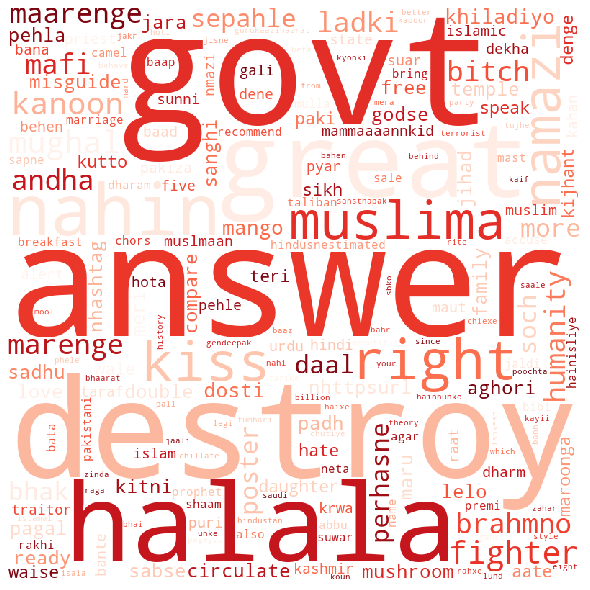

In [169]:
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud_ab) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show()

In [ ]:
non_off = get_for_wc(0)

In [ ]:
wordcloud_non_off = WordCloud(width = 800, height = 800, 
                background_color ='white', min_font_size = 10)

In [ ]:
wordcloud_non_off.fit_words( non_off )
wordcloud_non_off.recolor( colormap='viridis' )

In [ ]:
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud_non_off) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show()

In [ ]:
off_map = get_for_wc(2)

In [ ]:
print ( off_map )

In [ ]:
wordcloud_off = WordCloud(width = 800, height = 800, 
                background_color ='white', min_font_size = 10)

In [ ]:
wordcloud_off.fit_words( off_map )
wordcloud_off.recolor( colormap='viridis' )

In [839]:
def show(sentences, is_off): 
    
    #fig, axn = plt.subplots( len(sentences), 1 )
    #fig.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=5, hspace=20)
    #fig.tight_layout()

    to_seq = tokenizer_keras.texts_to_sequences( sentences )
    to_seq = sequence.pad_sequences(to_seq, maxlen=len_max, padding = "post")
    
    #for i, ax in enumerate( axn.flat ):
    for i in range( len(sentences) ):
            
        fig = plt.figure(i, figsize=(20, 1))
        fig.tight_layout()
        plt.xticks(rotation=0)
        
        seq = sentences[i]
        words = seq.split(" ")
        arr = np.array( to_seq[i] )

        arr = np.reshape(arr, (1, arr.shape[0]))
        
        weights = attn_model.predict(arr)
        val = []
        total = 0
        for j in range( len(words) ):
            val.append( weights[0,j] )
            total += weights[0,j]

        d = {}
        d[""] = pd.Series(val, index=words)

        df = pd.DataFrame(d)
        df.reindex(sentences[i].split(" "))
        df = df.transpose()
        
        cmap = None
        if is_off[i]:
            cmap = "Reds"
        else:
            cmap = "Greens"
            
        sns.set(font_scale=1.2)
        ax = sns.heatmap(df, annot=Truex, linewidths=0.5, cmap=cmap,#"YlGnBu" "RdBu_r",
                      cbar_kws={"orientation": "vertical"}, square = False)
        
        ax.xaxis.tick_top()
        ax.tick_params(length=0)
        #sns.heatmap(df, ax=ax, annot=False, cbar_ax=None, cbar=False, linewidths=.0, cmap="YlGnBu")#"Oranges")#"RdBu_r")
    
    plt.show()
    #return fig

In [840]:
sent = ['tu madarchod hai', 'tu gaandu hai', 'tu chutiya hai', 'tu musalmaan hai']

In [841]:
x = ['sab musalmaan bhaiyo ko id mubarak',
       'aaj India Gate pe hidje ki rally thi',
       'In rape cases ki vajah se ladies feel afraid to go out',
    'aatankwadi hain tu',
    'vo pakistan se hai',
    'sab neta aise hai',
    'do not behave like a pakistani jihadi',
    'musalmaani aaadmi ko nahi banayenge neta']

In [842]:
is_off = [True, False, True, True, True, True, True, False]

In [843]:
print (x)

['sab musalmaan bhaiyo ko id mubarak', 'aaj India Gate pe hidje ki rally thi', 'In rape cases ki vajah se ladies feel afraid to go out', 'aatankwadi hain tu', 'vo pakistan se hai', 'sab neta aise hai', 'do not behave like a pakistani jihadi', 'musalmaani aaadmi ko nahi banayenge neta']


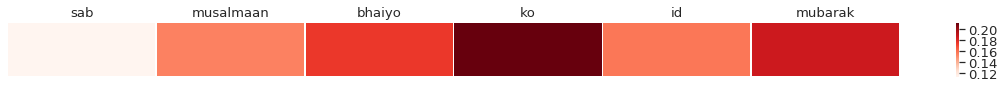

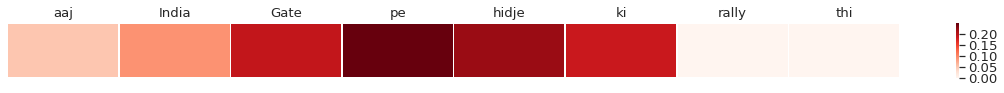

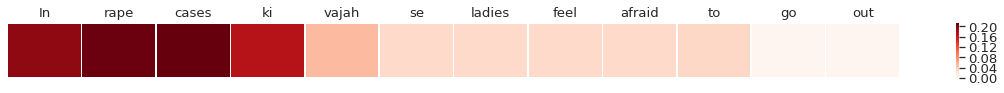

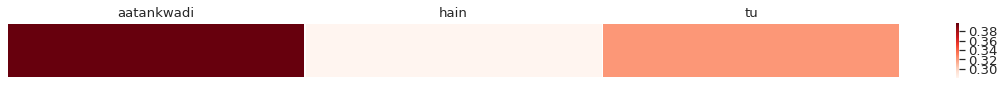

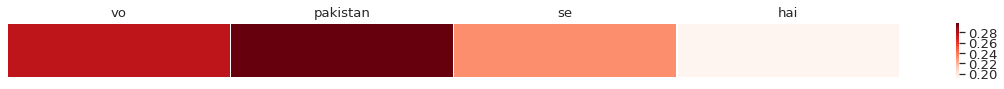

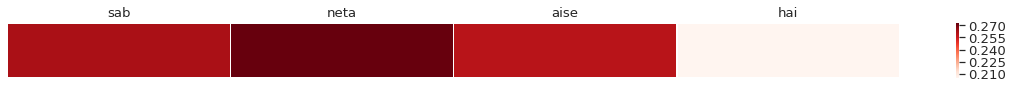

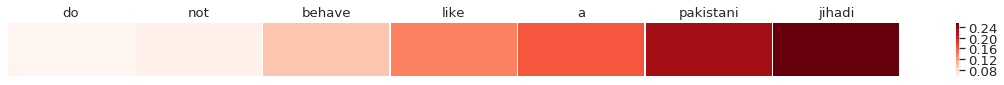

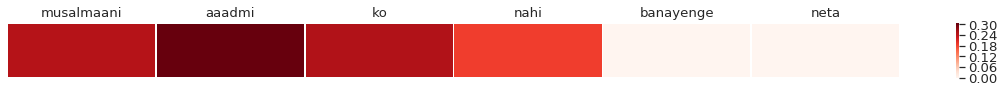

In [844]:
show(x, is_off)

In [754]:
import random

In [591]:
ind = random.randint( 0, train_df.shape[0] )
train_df.loc[ind, 'content']

'user user user abe gaandu housefull outaim khiladi ye sab framcise nahi hai kyaye txe2x80xa6 url'

In [560]:
def search_word(word):
    for i in range( train_df.shape[0] ):
        s = train_df.loc[i, 'content']
        if word in s:
            print (s)

In [592]:
search_word("india")

user you madarchod in user screw air india and still have audacity to question government kya khate ho aur kya sochte ho xe2x80xa6 url
user bhadva vo khali tu hay tihar ki tyari kar baki sara india safe haytune life me ek hi kam achha kixe2x80xa6 url
user user user user user india deta h leni to usy atii hi nahi nchutia
user not an indian seaplane and certainly not a gujrati pilot now i understand that hashtag be electioxe2x80xa6 url
user aur ye log bolte hai vikas ho rha haibc india ke culture ki maa bhen ek kr di hainnamo namo namo ane chutiya bano xf0x9fx98x82xf0x9fx98x82xf0x9fx91x8fxf0x9fx91x8fxf0x9fx91x8f
user when kejri talk against surgical strike pakistan take a dig at india haraam zaade
user wah kya baat h ye h india k insaan jo jaanvar se b bekaar h
rt user me in this world india be greatxe2x99xa5xefxb8x8f pakistan tatti ka lodannme in mar incredible india xe2x99xa5xefxb8x8f pakistan hai hee jhaat ka pxe2x80xa6
user user user oh mrhasindu or pasindu three for india and zero f